# Copyright

<PRE>
This iPython notebook was prepared to the subject "Deep Learning in Practice with Python and LUA" held at the Budapest University of Technology and Economics.
Course website: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning research: http://smartlab.tmit.bme.hu/deep-learning
This notebook is based on the work of Nicolas P. Rougier, protected by a BSD license: http://www.labri.fr/perso/nrougier/downloads/mlp.py

Re-use or publication of any part of the notebook is only permitted with the written consent of the authors.

2020 (c) Bálint Gyires-Tóth (toth.b at tmit dot bme dot hu), Márk Császár

In Hungarian:
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
Jelen notebook Nicolas P. Rougier munkája alapján készült, melyet BSD licensz véd: http://www.labri.fr/perso/nrougier/downloads/mlp.py

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

In [ ]:
# My homework is based on the code of the practical course. The modification are between '# HF2 start momentum and/or l1reg and/or l2reg' and '# HF2 end momentum and/or l1reg and/or l2reg' comments.
# Essential parts of the original code are kept and the comments are translated to English.

In [ ]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
from sklearn import preprocessing
import copy

In [ ]:
# Define activation and deactivation function
def activation(x):
    return 1 / (1 + np.exp(-x))

def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

In [ ]:
# Create MLP class
class MLP:
    
    # Initialization of the network
    def __init__(self, *args):
        # Add random seed
        np.random.seed(123)
        # Number of layers is the same as the input parameters
        self.shape = args
        n = len(args)
        # Create layers
        self.layers = []
        # Create input layer (there i a +1 for the bias)
        self.layers.append(np.ones(self.shape[0]+1))
        # Create hidden and output layers
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Create weight matrices
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # Create dw that contains the last modification of the weights
        self.dw = [0,]*len(self.weights)
        # Initialize weights
        self.reset()
        # HF2 start momentum, l1reg, l2reg
        # Define possible methods. It is used later in the propagate_backward function.
        self.methods = ['momentum', 'l1reg', 'l2reg', 'none']
        # HF2 start momentum, l1reg, l2reg
        
    
    # Reinitialize weight
    def reset(self):
        for i in range(len(self.weights)):
            # Random numbers in range of [0,1)
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # Scale the weights into -1..1 range
            self.weights[i][...] = (2*Z-1)*1

    # Forward propagation of the input data to the output layer
    def propagate_forward(self, data):
        # Set input layer
        self.layers[0][0:-1] = data
        # Use sigmoid activation function and matrix multiplications
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Return with the estimated value by the network
        return self.layers[-1]
    
    # Backward propagation
    # HF2 start momentum, l1reg, l2reg
    # Function input parameters are modified. This function is called in the learn function.
    def propagate_backward(self, target, lrate=0.1, method = 'none', momentum_value = 0.9, lambda_value = 0.001):
        """
        Parameter description
        ----------
        target: float
            Target value (it is also present in the original code)
        lrate : float, optional
            Learning rate (it is also present in the original code)
        method : str, optional
            The method that is used in the weight modification phase. Possible values are: 'momentum' for momentum calculation, 'l1reg' for L1 regularization, 
            'l2reg' for L2 regularization, 'none' for no additional calculation (default: 'none'). 
        momentum_value : float, optional
            The momentum parameter value for momentum calculation (default 0.9). It is used only if the method is set to 'momentum'.
        lambda_value : float, optional
            The lambda parameter value for L1 or L2 regulariozation calculation (default: 0.001). It is used only if the method is set to 'l1reg' or 'l2reg'.
        """
        # HF2 end momentum, l1reg, l2reg
        deltas = []
        # Calculate error in the output layer
        error = -(target-self.layers[-1]) # y-y_kalap
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Calculate gradient in the hidden layer(s)
        for i in range(len(self.shape)-2,0,-1):
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Modify weights
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)

            # HF2 start momentum, l1reg, l2reg
            # Check method input parameter and calculate correction value based on the given method
            if method in self.methods:
              # HF2 start momentum
              # If method input is 'momentum', calculate the correction value based on its formula. If momentum_value is not set than use the default value.
              if method == 'momentum':
                correction = momentum_value*self.dw[i]
              # HF2 end momentum
              # HF2 start l1reg
              # If method input is 'l1reg' (L1 regularization), calculate the correction value based on its formula. If lambda_value is not set then use the default value.
              elif method == 'l1reg':
                correction = -lrate * lambda_value * np.sign(self.weights[i])
              # HF2 end l1reg
              # HF2 start l2reg
              # If method input is 'l2reg' (L2 regularization), calculate the correction value based on its formula. If lambda_value is not set then use the default value.
              elif method == 'l2reg':
                correction = -lrate * lambda_value * self.weights[i]
              # HF2 end l2reg
              # If 'none' is given as method input
              else:
                correction = 0
            # If invalid method input is given
            else:
              correction = 0

            # Modify weights with the given method (if invalid or method='none' is given, the correction value is zero)
            self.weights[i] += dw + correction
            # HF2 end momentum, l1reg, l2reg

            # Store weight modofication
            self.dw[i] = dw

        # Return with error
        return (error**2).sum()


In [ ]:
# HF2 start momentum, l1reg, l2reg
# Add new input parameters to learn function. They are the same as the new input parameters in the propagate_backward function.
def learn(network, X, Y, valid_split, test_split, epochs=20, lrate=0.1, method = 'none', momentum_value = 0.9, lambda_value = 0.01):
# HF2 end momentum, l1reg, l2reg
        # Split train-validation-test samples
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # Standardize
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # Add the input and outputs in the same order to the three different datasets
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
        # Train phase, train 1-1 random samples epoch variable times
        for i in range(epochs):
            # Use SGD (Stochastic Gradient Descent): propagate forward each item on the network then propagate backward.
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                # HF2 start momentum, l1reg, l2reg
                # Add new input parameters to propagate_backward function
                train_err += network.propagate_backward( Y_train[k], lrate, method, momentum_value, lambda_value  )
                # HF2 end  momentum, l1reg, l2reg
            train_err /= X_train.shape[0]

            # Validation phase
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Test phase
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [ ]:
# Create neural network with 2 inputs, 10 hidden neurons and 1 output
network = MLP(2,10,1)

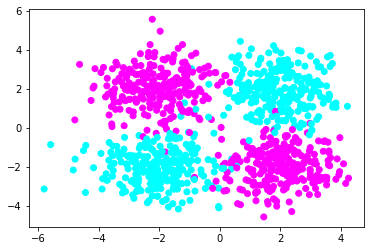

In [ ]:
#  Create data (XOR data with noise)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# Plot data
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

0 epoch, train_err: 0.2419, valid_err: 0.2221
1 epoch, train_err: 0.1993, valid_err: 0.1661
2 epoch, train_err: 0.1354, valid_err: 0.1102
3 epoch, train_err: 0.0904, valid_err: 0.0821
4 epoch, train_err: 0.0688, valid_err: 0.0687
5 epoch, train_err: 0.0579, valid_err: 0.0612
6 epoch, train_err: 0.0516, valid_err: 0.0564
7 epoch, train_err: 0.0475, valid_err: 0.0531
8 epoch, train_err: 0.0446, valid_err: 0.0507
9 epoch, train_err: 0.0425, valid_err: 0.0488
10 epoch, train_err: 0.0408, valid_err: 0.0473
11 epoch, train_err: 0.0395, valid_err: 0.0461
12 epoch, train_err: 0.0384, valid_err: 0.0451
13 epoch, train_err: 0.0375, valid_err: 0.0442
14 epoch, train_err: 0.0367, valid_err: 0.0435
15 epoch, train_err: 0.0360, valid_err: 0.0429
16 epoch, train_err: 0.0354, valid_err: 0.0423
17 epoch, train_err: 0.0349, valid_err: 0.0419
18 epoch, train_err: 0.0344, valid_err: 0.0414
19 epoch, train_err: 0.0340, valid_err: 0.0411

--- TESZTELÉS ---

0 [-0.49551261 -0.7444607 ] 0.13  (elvart eredmeny

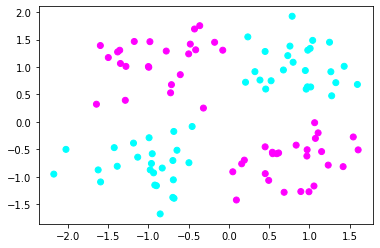

In [ ]:
# Start train/test
network.reset()
            
# HF2 start momentum, l1reg, l2reg
# Using different methods and parameters
# They do not contain the best results but are given as an example for each method. However, after a few evaluations the best result was using the momentum method with the default value of 0.9.
learn(network, X, Y, 0.2, 0.1, method='momentum') #19 epoch, train_err: 0.0340, valid_err: 0.0411
#learn(network, X, Y, 0.2, 0.1, method='momentum', momentum_value=0.8) #19 epoch, train_err: 0.0346, valid_err: 0.0442
#learn(network, X, Y, 0.2, 0.1, method='l1reg') #19 epoch, train_err: 0.2503, valid_err: 0.2501
#learn(network, X, Y, 0.2, 0.1, method='l1reg', lambda_value=0.001) #19 epoch, train_err: 0.0641, valid_err: 0.0694
#learn(network, X, Y, 0.2, 0.1, method='l2reg') #19 epoch, train_err: 0.2525, valid_err: 0.2501
#learn(network, X, Y, 0.2, 0.1, method='l2reg', lambda_value=0.001) #19 epoch, train_err: 0.0790, valid_err: 0.0833
#learn(network, X, Y, 0.2, 0.1) #19 epoch, train_err: 0.0404, valid_err: 0.0460
# HF2 start momentum, l1reg, l2reg